In [1]:
import random
import string
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
param_dict = {0:"learning_rate",
             1:"ngrams",
             2:"vocab_size",
             3:"embedding_size",
             4:"max_sentence_length",
             5:"batch_size"}

In [36]:
def clean_df(path=None,n=None,delete_cols=None):
    """Takes as input a csv, path. Cleans and returns the
    validation accuracy dataset."""
    gram_losses = pd.DataFrame(pd.read_csv(path,header=None))
    
    ## grams
    hyperparam_sets_ = []

    for i in [*range(1,gram_losses.shape[1])]:
        hyperparams = [*gram_losses[i].iloc[:6]]
        hyperparam_sets_.append(hyperparams)

    hyperparam_sets_ = pd.Series(hyperparam_sets_).\
    apply(lambda x: [float(x[i]) for i in [*range(len(x))]])

    gram_losses = gram_losses.dropna(1)
    gram_losses = gram_losses.drop([*range(6)],0)
    gram_losses = gram_losses.T
    gram_losses["params"] = [*hyperparam_sets_]
    param_cols_ = {}

    for key in [*param_dict.keys()]:
        param_cols_[param_dict[key]] = gram_losses["params"].\
        apply(lambda x: x[key])

    param_cols_ = {}
    for key in [*param_dict.keys()]:
        param_cols_[param_dict[key]] = gram_losses["params"].\
        apply(lambda x: x[key])

    for key in [*param_cols_.keys()]:
        gram_losses[key] = param_cols_[key]

    gram_losses = gram_losses.drop("params",1)
    gram_losses["ngrams"] = [n for i in [*range(len(gram_losses))]]
    gram_losses = gram_losses.drop([*range(7,int(delete_cols))],1)

    gram_losses["val_acc"] = gram_losses[6].\
    apply(lambda x: str(x).replace("[","").\
          replace("]","").split(", "))

    gram_losses = gram_losses.drop(6,1)
    
    return gram_losses

In [38]:
clean_df(path="bigram_losses.csv",n=2,delete_cols=46).head(3)

,learning_rate,ngrams,vocab_size,embedding_size,max_sentence_length,batch_size,val_acc
1,0.001,2,25000.0,100.0,200.0,32.0,"[53.94, 60.94, 58.42, 56.48, 66.46, 74.06, 76...."
2,0.001,2,25000.0,100.0,200.0,64.0,"[57.24, 58.44, 63.68, 71.98, 73.38, 76.72, 77...."
3,0.001,2,25000.0,200.0,200.0,32.0,"[52.34, 58.34, 61.44, 66.76, 63.48, 71.36, 75...."


In [39]:
hyperparams = pd.concat([clean_df(path="unigram_losses.csv",n=1,delete_cols=46),
                              clean_df(path="bigram_losses.csv",n=2,delete_cols=46),
                              clean_df(path="trigram_losses.csv",n=3,delete_cols=46)],0)

hyperparams["optimizer"] = ["Adam" for x in [*range(len(hyperparams))]]

sgd_uni_df = clean_df(path="unigram_SGD_losses.csv",n=1,delete_cols=46)
sgd_uni_new = clean_df(path="unigram_SGD_losses_new.csv",n=1,delete_cols=26)
sgd_bi_df = clean_df(path="bigram_sgd_losses.csv",n=2,delete_cols=46)

sgd_uni_df["optimizer"] = ["SGD" for x in [*range(len(sgd_uni_df))]]
sgd_uni_new["optimizer"] = ["SGD" for x in [*range(len(sgd_uni_new))]]
sgd_bi_df["optimizer"] = ["SGD" for x in [*range(len(sgd_bi_df))]]

hyperparams = pd.concat([hyperparams,
                        sgd_uni_df,
                        sgd_uni_new,
                        sgd_bi_df],0)

hyperparams["model_no"] = [*range(len(hyperparams))] 
hyperparams = hyperparams.set_index("model_no",drop=True)

print ("Total number of hyperparameter combinations included in the search is: "+ str(hyperparams.shape[0]))

Total number of hyperparameter combinations included in the search is: 220


In [40]:
hyperparams["model_no"] = [*range(len(hyperparams))] 
hyperparams = hyperparams.set_index("model_no",drop=True)

In [41]:
hyperparams.shape

(220, 8)

In [42]:
fast_index = np.where(np.array(hyperparams["val_acc"].apply(lambda x: len(x)))==30)
slow_index = np.where(np.array(hyperparams["val_acc"].apply(lambda x: len(x)))==60)

In [43]:
fast = hyperparams.iloc[fast_index]
slow = hyperparams.iloc[slow_index]

Text(0.5,1,'Adam Validation Accuracy')

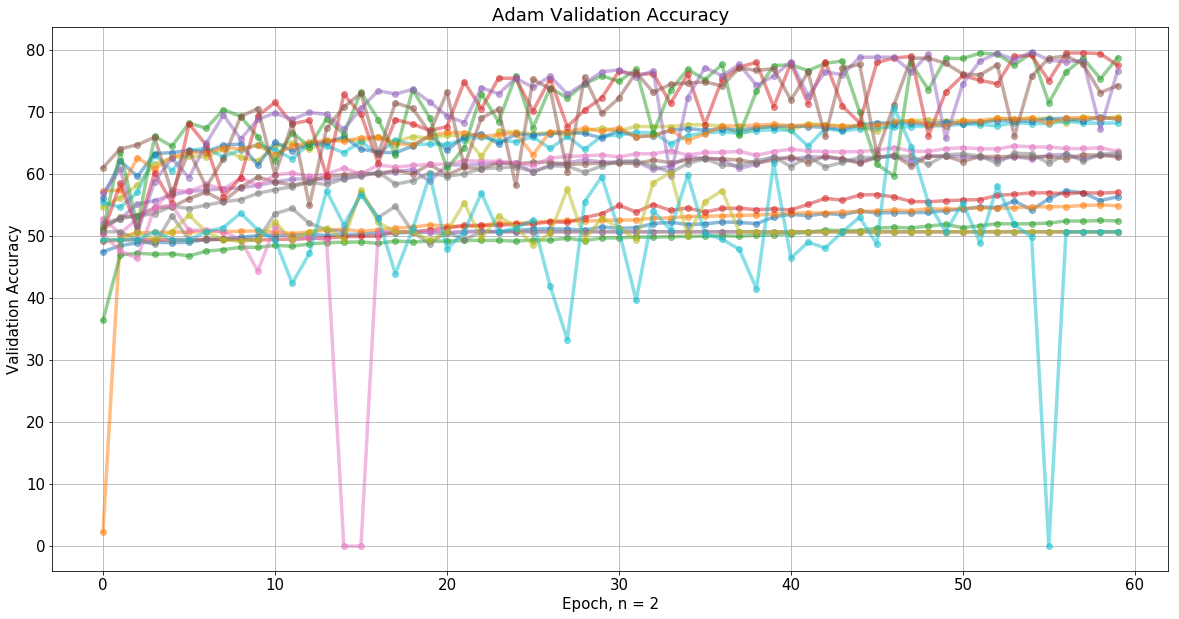

In [45]:
n = 2
# EMBED_DIM = 200
# VOCAB_SIZE = 25000

plt.figure(figsize=(20,10))

lr_try = slow[(slow["ngrams"]==n)&(slow["optimizer"]=="SGD")]
first_last = [[],[]]
val_accs = {}
for i in [*range(lr_try.shape[0])]:
    val_accs[i] = [float(x) for x in [*lr_try.iloc[i]["val_acc"]]]

for i in [*range(lr_try.shape[0])]:
    plt.plot(val_accs[i],
            linewidth=3.5,
            alpha=0.5,
            marker="o",
            label=str([*lr_try[["ngrams","vocab_size","embedding_size","max_sentence_length","batch_size"]].iloc[i]]))
    
    first_last[0].append(lr_try.iloc[i]["val_acc"][0])
    first_last[1].append(lr_try.iloc[i]["val_acc"][-1])
plt.xticks()
plt.grid()
# plt.yticks(np.array(first_last).ravel())

plt.xlabel("Epoch, n = " + str(n))
plt.ylabel("Validation Accuracy")
plt.rcParams["font.size"] = 15

## it's a huge legend, but nice to see
# plt.legend(loc=4)

plt.title("Adam Validation Accuracy")

Text(0.5,1,'Adam Validation Accuracy')

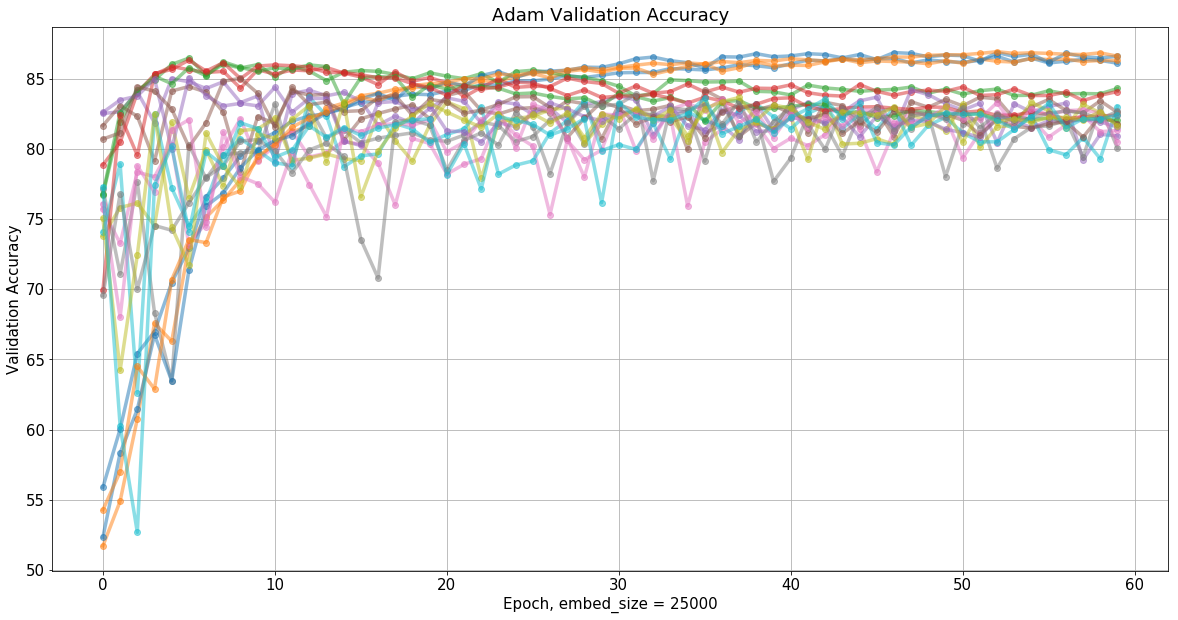

In [362]:
EMBED_DIM = 200

plt.figure(figsize=(20,10))

lr_try = adam_slow[(adam_slow["embedding_size"]==EMBED_DIM)&(adam_slow["ngrams"] != 3)]
first_last = [[],[]]
val_accs = {}
for i in [*range(lr_try.shape[0])]:
    val_accs[i] = [float(x) for x in [*lr_try.iloc[i]["val_acc"]]]

for i in [*range(lr_try.shape[0])]:
    plt.plot(val_accs[i],
            linewidth=3.5,
            alpha=0.5,
            marker="o",
            label=str([*lr_try[["ngrams","vocab_size","embedding_size","max_sentence_length","batch_size"]].iloc[i]]))
    
    first_last[0].append(lr_try.iloc[i]["val_acc"][0])
    first_last[1].append(lr_try.iloc[i]["val_acc"][-1])
plt.xticks()
plt.grid()
# plt.yticks(np.array(first_last).ravel())

plt.xlabel("Epoch, embed_size = " + str(VOCAB_SIZE))
plt.ylabel("Validation Accuracy")
plt.rcParams["font.size"] = 15
# plt.legend()

plt.title("Adam Validation Accuracy")